In [304]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

In [2]:
#Lectura de datos 
data = pd.read_csv('DEPURACION_FINAL.csv', sep=',')
data

,AÑO,MES,DIA,FECHA,HORA,KW-H
0,2015,1,jueves,1,0,3200
1,2015,1,jueves,1,1,3200
2,2015,1,jueves,1,2,2400
3,2015,1,jueves,1,3,2400
4,2015,1,jueves,1,4,2400
...,...,...,...,...,...,...
43819,2019,12,martes,31,19,3400
43820,2019,12,martes,31,20,3600
43821,2019,12,martes,31,21,3800
43822,2019,12,martes,31,22,4000


In [3]:
#Verificacion de nans 
data.isnull().values.any()
data.isnull().sum().sum()

data.isnull().sum()

AÑO      0
MES      0
DIA      0
FECHA    0
HORA     0
KW-H     0
dtype: int64

In [4]:
#Variable categrica DIA a numérica
#TODO Borrar al final de cuentas no se usa este dato 
data['DIA'] = data['DIA'].map({'lunes': 1 ,
                                           'martes': 2,
                                           'miercoles': 3,
                                           'miércoles': 3,
                                           'jueves': 4 , 
                                           'viernes': 5, 
                                           'sábado': 6,
                                           'sabado': 6,  #inconsistencia en la data por las tildes
                                           'domingo': 7})




In [5]:
data.tail(50)
# data.to_csv('data_total.csv')


,AÑO,MES,DIA,FECHA,HORA,KW-H
43774,2019,12,7,29,22,3200
43775,2019,12,7,29,23,2800
43776,2019,12,1,30,0,2400
43777,2019,12,1,30,1,2400
43778,2019,12,1,30,2,2000
43779,2019,12,1,30,3,2000
43780,2019,12,1,30,4,2000
43781,2019,12,1,30,5,2000
43782,2019,12,1,30,6,2000
43783,2019,12,1,30,7,1800


In [6]:
#Llevamos la hora y la fecha para los indices porque lo que nos interesa es KW-H
from datetime import datetime 
data_final = pd.DataFrame()
fechas_dt = []
kwh_dt = []
for registro in data.values:
    fecha = "{}-{}-{} {}".format(registro[0], registro[1], registro[3], registro[4])
    fecha_dt = datetime.strptime(fecha, '%Y-%m-%d %H')
    fechas_dt.append(fecha_dt)
    kwh_dt.append(registro[5])
#Creamos un nuevo dataframe con el formato de fecha correcto y el valor de KW-H
data_final['FECHA'] = fechas_dt
data_final['KW-H'] = kwh_dt
data_final

,FECHA,KW-H
0,2015-01-01 00:00:00,3200
1,2015-01-01 01:00:00,3200
2,2015-01-01 02:00:00,2400
3,2015-01-01 03:00:00,2400
4,2015-01-01 04:00:00,2400
...,...,...
43819,2019-12-31 19:00:00,3400
43820,2019-12-31 20:00:00,3600
43821,2019-12-31 21:00:00,3800
43822,2019-12-31 22:00:00,4000


In [7]:
data_final.to_csv('data_total_dattime.csv')

In [8]:
#Llevamos la FECHA al indice de nuestro df, ahora solo tenemos una columna de datos
data_final.set_index('FECHA', drop=True, inplace = True)
data_final

,KW-H
FECHA,
2015-01-01 00:00:00,3200
2015-01-01 01:00:00,3200
2015-01-01 02:00:00,2400
2015-01-01 03:00:00,2400
2015-01-01 04:00:00,2400
...,...
2019-12-31 19:00:00,3400
2019-12-31 20:00:00,3600
2019-12-31 21:00:00,3800


In [9]:
#Dividir los datos de entrenamiento y de test
# No se puede utilizar train test split, debemos dividir en el ultimo segmento 
#Tomamos los datos para validacion el 18%, pero del final de los datos (todo 2019 menos enero)
size = int(0.18292*data_final.shape[0])
data_test = data_final[-size:]
data_train = data_final[:-size]
data_train


,KW-H
FECHA,
2015-01-01 00:00:00,3200
2015-01-01 01:00:00,3200
2015-01-01 02:00:00,2400
2015-01-01 03:00:00,2400
2015-01-01 04:00:00,2400
...,...
2019-01-31 19:00:00,3300
2019-01-31 20:00:00,3300
2019-01-31 21:00:00,3400


In [10]:
#Transformacion de datos a numerica

data_train['KW-H'] = [valor.replace(",", ".") for valor in data_train['KW-H'] ]
data_train['KW-H'] = [float(valor) for valor in data_train['KW-H'] ]

data_test['KW-H'] = [valor.replace(",", ".") for valor in data_test['KW-H'] ]
data_test['KW-H'] = [float(valor) for valor in data_test['KW-H'] ]

data_train

/Users/javiererazo/opt/anaconda3/envs/powerdemand/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/javiererazo/opt/anaconda3/envs/powerdemand/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/javiererazo/opt/anaconda3/envs/powerdemand/lib/python3.7/site-packages/ipykernel_launcher

,KW-H
FECHA,
2015-01-01 00:00:00,3200.0
2015-01-01 01:00:00,3200.0
2015-01-01 02:00:00,2400.0
2015-01-01 03:00:00,2400.0
2015-01-01 04:00:00,2400.0
...,...
2019-01-31 19:00:00,3300.0
2019-01-31 20:00:00,3300.0
2019-01-31 21:00:00,3400.0


In [11]:
#Normalizacion de los datos
#Para LSTM es obligatoria la normalización, en este caso lo hacemos de 0 a 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
data_train_scaled = sc.fit_transform(data_train)
print(data_train_scaled.shape)
data_train_scaled
 


(35808, 1)


array([[0.66666667],
       [0.66666667],
       [0.5       ],
       ...,
       [0.70833333],
       [0.75      ],
       [0.54166667]])

In [12]:
#Tenemos que entrenar la red por bloques de datos 
#Time_step es el tamaño del bloque 
#Cada n datos genera una salida 
#Tomamos bloques de 60 datos consecutivos 
time_step = 60 
X_train = [] #Lista de conjuntos de 60 datos 
Y_train = []
m = len(data_train_scaled)
for i in range(time_step, m):
    X_train.append(data_train_scaled[i-time_step:i, 0]) #Guardamos 60 valores
    Y_train.append(data_train_scaled[i, 0]) #Buscamos predecir el dato time_step + 1, no la var KW
X_train, Y_train = np.array(X_train), np.array(Y_train) #Usamos np por reshape y optimizacion



In [13]:
X_train.shape, Y_train.shape

((35748, 60), (35748,))

In [14]:
# pd.DataFrame(X_train).to_csv('x_train.csv')
# pd.DataFrame(Y_train).to_csv('y_train.csv')

In [15]:
#Obligatorio el reshape de los datos, es obligatorio por Keras, nos pide ingresar un array de 3 dim
#Llevamos de dos a 3 dimensiones nuestro arreglo 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #Agregamos una nueva dimension
X_train.shape, Y_train.shape

((35748, 60, 1), (35748,))

In [16]:
#MODELO
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


In [17]:
#rmsprop LOS MEJORES RESULTADOS
dim_entrada = (X_train.shape[1],X_train.shape[2])
dim_salida = 1 
num_neuronas = 10


model = Sequential()
#Capa 1 
model.add(LSTM(units=num_neuronas, return_sequences = True, input_shape=dim_entrada))
model.add(Dropout(0.4))
# #Capa 2
model.add(LSTM(units=4))
# model.add(Dropout(0.2))


#capa de salida 
model.add(Dense(units = dim_salida))
model.compile(optimizer='rmsprop', loss='mse', metrics = ['mean_absolute_error']) #mean_squared_error

#Entrenamiento 
history = model.fit(X_train, Y_train, epochs = 10, batch_size = 64)

2022-01-22 08:27:01.368669: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-22 08:27:01.369342: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/10
35748/35748 [==============================] - 117s 3ms/step - loss: 0.0220 - mean_absolute_error: 0.0917
Epoch 2/10
35748/35748 [==============================] - 148s 4ms/step - loss: 0.0062 - mean_absolute_error: 0.0519
Epoch 3/10
35748/35748 [==============================] - 153s 4ms/step - loss: 0.0046 - mean_absolute_error: 0.0432
Epoch 4/10
35748/35748 [==============================] - 154s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0388
Epoch 5/10
35748/35748 [==============================] - 147s 4ms/step - loss: 0.0035 - mean_absolute_error: 0.0364
Epoch 6/10
35748/35748 [==============================] - 163s 5ms/step - loss: 0.0033 - mean_absolute_error: 0.0354
Epoch 7/10
35748/35748 [==============================] - 148s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0346
Epoch 8/10
35748/35748 [==============================] - 161s 5ms/step - loss: 0.0032 - mean_absolute_error: 0.0342
Epoch 9/10
35748/35748 [==============================] - 167s 5

In [18]:
data_test

,KW-H
FECHA,
2019-02-01 00:00:00,2500.0
2019-02-01 01:00:00,2500.0
2019-02-01 02:00:00,2200.0
2019-02-01 03:00:00,2200.0
2019-02-01 04:00:00,2200.0
...,...
2019-12-31 19:00:00,3400.0
2019-12-31 20:00:00,3600.0
2019-12-31 21:00:00,3800.0


In [19]:
x_test  = data_test.values
x_test = sc.transform(x_test)
# # x_test
X_test = []
for i in range(time_step, len(x_test)):
    X_test.append(x_test[i-time_step: i, 0])
X_test= np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape
prediccion = model.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

In [20]:
len(prediccion)

7956

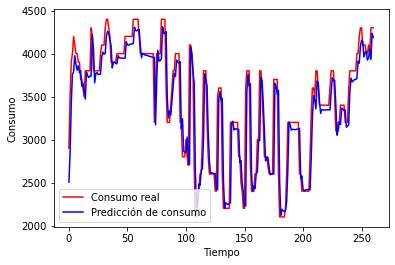

In [207]:
#Grafica de valores
# Y_test #Aun no defnido 
plt.plot(data_test.values[60:321], color='red', label='Consumo real')
plt.plot(prediccion[:261], color='blue', label='Predicción de consumo')
plt.xlabel('Tiempo')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [220]:
#Union de datos 
#LSTM nos predice el dato time_step + 1 por tanto debemos unir a partir del dato 61 de nuestro data_test
data_test_slic  = data_test[60:].copy()
data_test_pred = pd.concat([data_test_slic, 
                  pd.DataFrame(prediccion, 
                               columns=['KW-H_PRED'], 
                               index = data_test_slic.index)], 
                 axis =1)
# print(data_test_slic.shape)
# print(prediccion.shape)
# print(data_test_slic)
# print(prediccion)
data_test_pred.head(20)


,KW-H,KW-H_PRED
FECHA,,
2019-02-03 12:00:00,2900.0,2505.201172
2019-02-03 13:00:00,3500.0,2842.103760
2019-02-03 14:00:00,3900.0,3419.429932
2019-02-03 15:00:00,4000.0,3757.582520
2019-02-03 16:00:00,4200.0,3787.280273
2019-02-03 17:00:00,4100.0,3974.216553
2019-02-03 18:00:00,4000.0,3877.532959
2019-02-03 19:00:00,4000.0,3807.690918
2019-02-03 20:00:00,3900.0,3858.438232


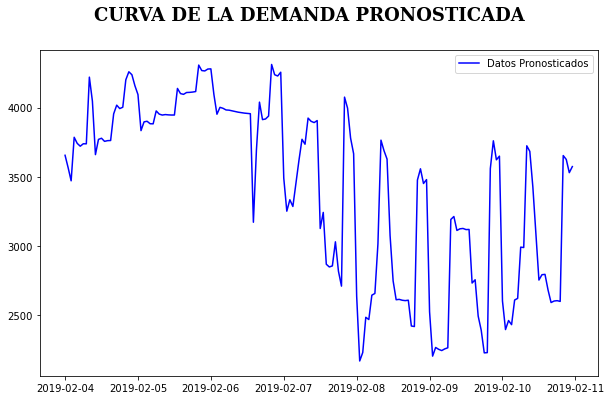

In [247]:
# Figura 5.8: Curva de la demanda eléctrica pronosticada
#Los primeros 7 dias(completos) de la prediccion (4 de febrero)
semana_estudio_test_pred = data_test_pred[
    data_test_pred.index.get_loc('2019-02-04 00:00:00'):
    data_test_pred.index.get_loc('2019-02-11 00:00:00')]

semana_estudio_test = semana_estudio_test_pred['KW-H']
semana_estudio_pred = semana_estudio_test_pred['KW-H_PRED']
# semana_estudio_pred
plt.figure(figsize=(10,6))
plt.plot(semana_estudio_pred, 
           color='blue', 
           label='Datos Pronosticados')
plt.suptitle('CURVA DE LA DEMANDA PRONOSTICADA',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()
plt.show()


In [251]:
# Tabla 5.2: Análisis descriptiva con datos reales de la demanda eléctrica
data_pred_febr = semana_estudio_pred
maximo = np.max(data_pred_febr)
print('Máximo = {}'.format(maximo))
minimo = np.min(data_pred_febr)
print('Mínimo = {}'.format(minimo))
# q75, q25 = np.percentile(data_estudio['KW-H'], [75, 25])
# rango = q75 - q25
rango = maximo - minimo
print('Rango = {}'.format(rango))
media = np.mean(data_pred_febr)
print('Media = {}'.format(media))
mediana = data_pred_febr.median()
print('Mediana = {}'.format(mediana))
varianza = data_pred_febr.var()
print('Varianza = {}'.format(varianza))
std = np.std(data_pred_febr)
print('Desviación Estándar = {}'.format(std))
coef_var = np.std(data_pred_febr) /np.mean(data_pred_febr) * 100
print('Coeficiente de variación = {} %'.format(coef_var))
# lim_max, lim_min = np.percentile((data_pred_febr), [75, 25])
lim_max = media + 1 * std
lim_min = media - 1 * std
print('Límite máximo = {}'.format(lim_max))
print('Límite mínimo = {}'.format(lim_min))

data_pred_febr.describe()

Máximo = 4312.2998046875
Mínimo = 2167.185302734375
Rango = 2145.114501953125
Media = 3426.45361328125
Mediana = 3654.2578125
Varianza = 406066.78125
Desviación Estándar = 635.3343505859375
Coeficiente de variación = 18.54203857082212 %
Límite máximo = 4061.7879638671875
Límite mínimo = 2791.1192626953125


count     168.000000
mean     3426.453613
std       637.233704
min      2167.185303
25%      2793.122803
50%      3654.257812
75%      3955.288330
max      4312.299805
Name: KW-H_PRED, dtype: float64

In [252]:
#Funciones
def funcionConstante(x, constante):
    return constante

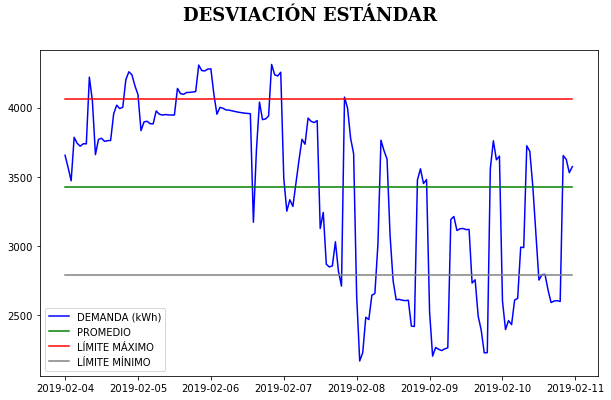

In [274]:
# Figura 5.9: Desviación estándar con datos de la demanda pronosticada

datos_kwh = semana_estudio_pred

plt.figure(figsize=(10,6))
plt.plot(datos_kwh.index,
         datos_kwh, 
         color = 'blue', 
         label = 'DEMANDA (kWh)')
plt.plot(datos_kwh.index,
         [funcionConstante(x, media) for x in datos_kwh], 
         color = 'green', 
         label = 'PROMEDIO')

plt.plot(datos_kwh.index,
           [funcionConstante(x, lim_max) for x in datos_kwh], 
           color = 'red', 
           label = 'LÍMITE MÁXIMO')

plt.plot(datos_kwh.index,
           [funcionConstante(x, lim_min) for x in datos_kwh], 
           color = 'gray', 
           label = 'LÍMITE MÍNIMO')


plt.suptitle('DESVIACIÓN ESTÁNDAR',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()

In [276]:
# Figura 5.10: Capacidades del proceso para la demanda de energía eléctrica (datos pronosticados - 1 semana)
#Exportacion de datos para sixpack capability system
semana_estudio_pred.to_csv('capabilities/prediccion_febrero.csv')
semana_estudio_pred

FECHA
2019-02-04 00:00:00    3655.280029
2019-02-04 01:00:00    3566.523682
2019-02-04 02:00:00    3470.608154
2019-02-04 03:00:00    3785.480225
2019-02-04 04:00:00    3741.437012
                          ...     
2019-02-10 19:00:00    2598.151855
2019-02-10 20:00:00    3653.235596
2019-02-10 21:00:00    3625.114746
2019-02-10 22:00:00    3529.561523
2019-02-10 23:00:00    3573.510010
Name: KW-H_PRED, Length: 168, dtype: float32

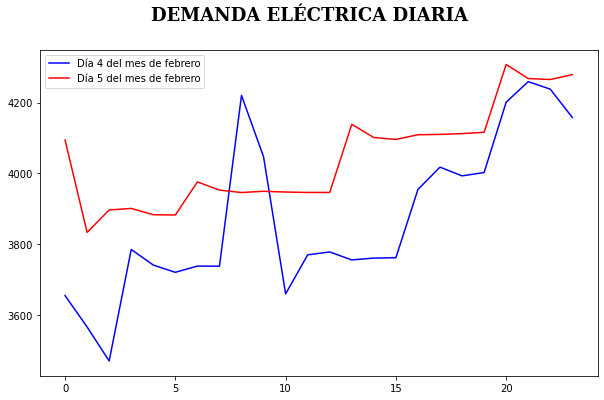

In [288]:
# Figura 5.11: Demanda eléctrica diaria con datos obtenidos del pronostico
# KW-H vs Hora del dia 

cuatro_feb_pred = semana_estudio_pred[
    semana_estudio_pred.index.get_loc('2019-02-04 00:00:00'):
    semana_estudio_pred.index.get_loc('2019-02-05 00:00:00')]
cinco_feb_pred = semana_estudio_pred[
    semana_estudio_pred.index.get_loc('2019-02-05 00:00:00'):
    semana_estudio_pred.index.get_loc('2019-02-06 00:00:00')]

serie = range(0,24)
plt.figure(figsize=(10,6))
plt.plot(serie,
         cuatro_feb_pred,
         color = 'blue', 
         label = 'Día 4 del mes de febrero')

plt.plot(serie, 
            cinco_feb_pred, 
            color = 'red', 
            label = 'Día 5 del mes de febrero')

plt.suptitle('DEMANDA ELÉCTRICA DIARIA',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()


In [290]:
# Figura 5.12: Capacidades del proceso para la demanda de energía eléctrica (datos pronosticados - 1 día)
# exportamos los datos del dia 3 del mes de febrero 
cinco_feb_pred.to_csv('capabilities/datos_cincoFeb_pred.csv')
cinco_feb_pred

FECHA
2019-02-05 00:00:00    4094.496094
2019-02-05 01:00:00    3833.658691
2019-02-05 02:00:00    3897.063965
2019-02-05 03:00:00    3901.343750
2019-02-05 04:00:00    3883.603516
2019-02-05 05:00:00    3882.759521
2019-02-05 06:00:00    3976.286377
2019-02-05 07:00:00    3953.080078
2019-02-05 08:00:00    3946.276367
2019-02-05 09:00:00    3949.774414
2019-02-05 10:00:00    3947.625244
2019-02-05 11:00:00    3946.518555
2019-02-05 12:00:00    3946.565186
2019-02-05 13:00:00    4138.872070
2019-02-05 14:00:00    4101.571289
2019-02-05 15:00:00    4096.158691
2019-02-05 16:00:00    4109.429688
2019-02-05 17:00:00    4110.395996
2019-02-05 18:00:00    4112.699219
2019-02-05 19:00:00    4116.383789
2019-02-05 20:00:00    4307.884766
2019-02-05 21:00:00    4268.145996
2019-02-05 22:00:00    4265.415039
2019-02-05 23:00:00    4279.197266
Name: KW-H_PRED, dtype: float32

In [291]:
cinco_feb_pred.describe()

count      24.000000
mean     4044.383789
std       141.101822
min      3833.658691
25%      3946.458008
50%      4035.391235
75%      4113.620361
max      4307.884766
Name: KW-H_PRED, dtype: float64

In [31]:
# mes = 1
# fecha_inicio = 25
# fecha_fin = 31
# year = 2019
# data_cuar_sem_dic = data[(data['FECHA'] >=fecha_inicio) &  
#                          (data['MES'] == mes )& 
#                          (data['AÑO'] == year)]
# data
# data_cuar_sem_dic['KW-H']
# data_pred_febr

0      2505.201172
1      2842.103760
2      3419.429932
3      3757.582520
4      3787.280273
          ...     
163    2987.989990
164    3723.897705
165    3683.575684
166    3426.270996
167    3088.732422
Name: KW-H PRED, Length: 168, dtype: float32

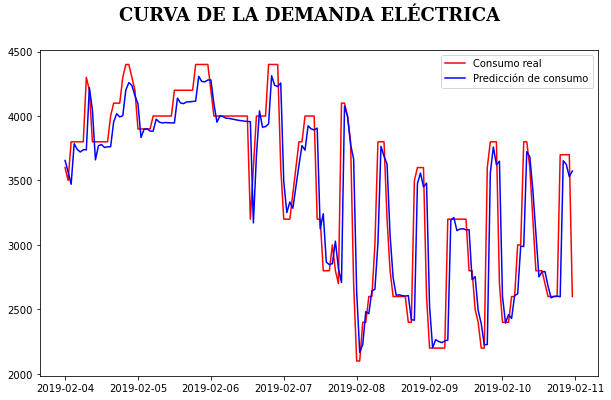

In [308]:
#CHECKPOINT
# Figura 5.13: Curva de la demanda eléctrica real vs pronosticada
#Pronostico para los dias en estudio
plt.figure(figsize=(10,6))
plt.plot(semana_estudio_test, 
         color='red', 
         label='Consumo real')
plt.plot(semana_estudio_pred, 
         color='blue', 
         label='Predicción de consumo')
plt.suptitle('CURVA DE LA DEMANDA ELÉCTRICA',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()
plt.show()

184.08048502604166


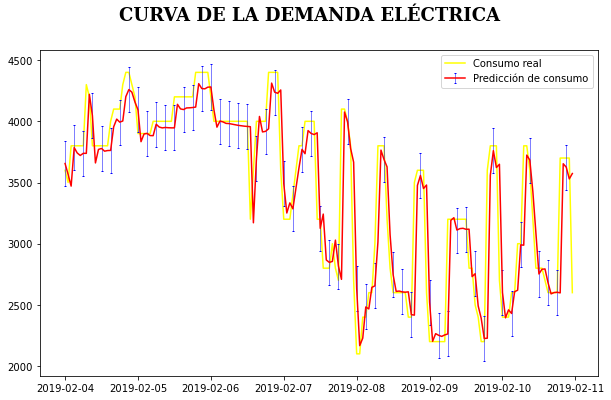

In [310]:
#Figura 5.14: Gráfica de error entre curva de la demanda eléctrica real y pronosticada (semanal)

# EROR_PROM = 0.033

x = semana_estudio_test.index
y = semana_estudio_test

x_pred = x
y_pred = semana_estudio_pred

me =  (abs(y- y_pred)).mean(axis=0) #Error medio de la semana
print(me)
yerror = me
plt.figure(figsize=(10,6))
plt.plot(semana_estudio_test.index, 
         semana_estudio_test,
         color='yellow', 
         label='Consumo real')
plt.errorbar(x_pred,
         y_pred,
         yerr = yerror,
         ecolor = 'blue', 
         elinewidth = 0.5,
         capsize = 1,
         errorevery = 3,
         color='red', 
         label='Predicción de consumo')
plt.suptitle('CURVA DE LA DEMANDA ELÉCTRICA',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()
plt.show()

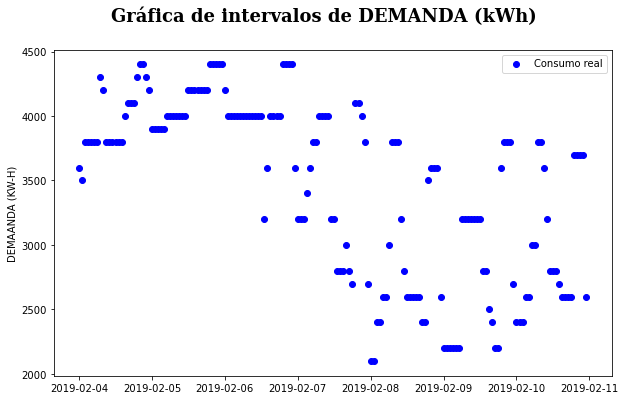

In [336]:
# Figura 5.15: Intervalos de la demanda de energía eléctrica (Datos reales y de pronóstico – 1 semana)
data_pred_test_hora = semana_estudio_test_pred.copy()
hora_temp = np.arange(0, 24)
hora = []
for _ in range(7):
    hora = np.concatenate([hora, hora_temp])
hora.shape

data_pred_test_hora = pd.concat([data_pred_test_hora, 
                  pd.DataFrame(hora, 
                               columns=['HORA'], 
                               index = data_pred_test_hora.index)], 
                 axis =1)
data_pred_test_hora_sort = data_pred_test_hora.sort_values('HORA')
data_pred_test_hora_sort.reset_index()
data_pred_test_hora_sort.index
plt.figure(figsize=(10,6))
plt.scatter(data_pred_test_hora_sort.index,
               data_pred_test_hora_sort['KW-H'], 
               color='blue', 
               label='Consumo real')

plt.suptitle('Gráfica de intervalos de DEMANDA (kWh)',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.ylabel('DEMAANDA (KW-H)')
plt.legend()
plt.show()


0.0031208934112358913


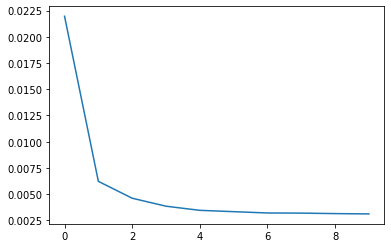

In [93]:
print(history.history['loss'][-1])
plt.plot(history.history['loss'])

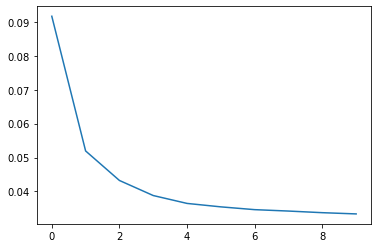

In [91]:
history.history['loss']
plt.plot(history.history['mean_absolute_error'])